In [7]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('D:/week6 data/data.csv')

# Convert TransactionStartTime to datetime
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Calculate Recency
max_date = df['TransactionStartTime'].max()
df['recency'] = df.groupby('CustomerId')['TransactionStartTime'].transform(lambda x: (max_date - x).dt.days)

# Calculate Frequency
df['frequency'] = df.groupby('CustomerId')['TransactionId'].transform('count')

# Calculate Monetary
df['monetary'] = df.groupby('CustomerId')['Amount'].transform('sum')

# Create Segment (You can define your own segmentation logic)
df['segment'] = pd.cut(df['monetary'], bins=3, labels=['Low', 'Medium', 'High'])

# Aggregate RFMS features
rfms = df.groupby('CustomerId').agg(
    recency=('recency', 'min'),
    frequency=('frequency', 'max'),
    monetary=('monetary', 'max'),
    segment=('segment', 'first')
).reset_index()

print(f"RFMS Features:\n{rfms.head()}")


RFMS Features:
        CustomerId  recency  frequency  monetary segment
0     CustomerId_1       83          1  -10000.0  Medium
1    CustomerId_10       83          1  -10000.0  Medium
2  CustomerId_1001       89          5   20000.0  Medium
3  CustomerId_1002       25         11    4225.0  Medium
4  CustomerId_1003       11          6   20000.0  Medium


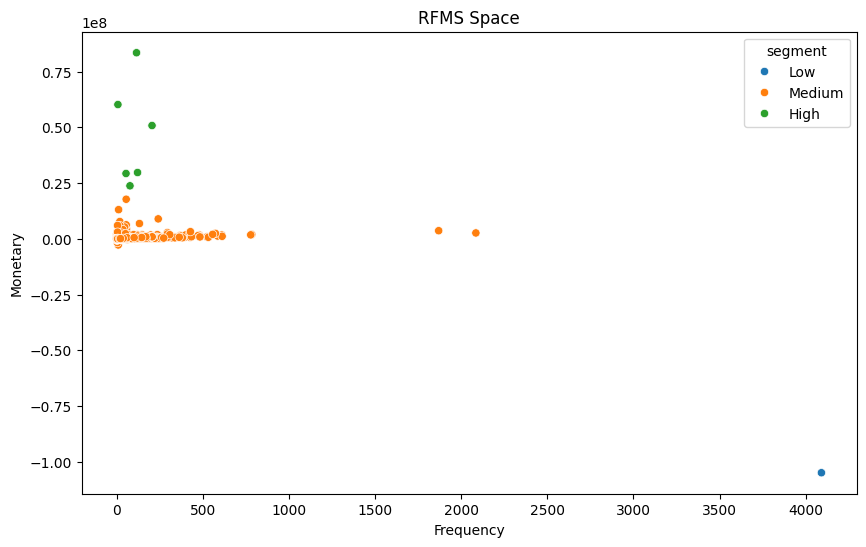

Labeled RFMS Features:
        CustomerId  recency  frequency  monetary segment  RFMS_score label
0     CustomerId_1       83          1  -10000.0  Medium     -9916.0   bad
1    CustomerId_10       83          1  -10000.0  Medium     -9916.0   bad
2  CustomerId_1001       89          5   20000.0  Medium     20094.0  good
3  CustomerId_1002       25         11    4225.0  Medium      4261.0   bad
4  CustomerId_1003       11          6   20000.0  Medium     20017.0   bad


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize RFMS features
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfms, x='frequency', y='monetary', hue='segment')
plt.title('RFMS Space')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Simple Boundary: Consider recency, frequency, and monetary thresholds
rfms['RFMS_score'] = rfms['recency'] + rfms['frequency'] + rfms['monetary']
rfms['label'] = np.where(rfms['RFMS_score'] > rfms['RFMS_score'].median(), 'good', 'bad')

print(f"Labeled RFMS Features:\n{rfms.head()}")


In [9]:
from sklearn.preprocessing import KBinsDiscretizer

# Binning using KBinsDiscretizer
kbins = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
rfms['recency_bin'] = kbins.fit_transform(rfms[['recency']])
rfms['frequency_bin'] = kbins.fit_transform(rfms[['frequency']])
rfms['monetary_bin'] = kbins.fit_transform(rfms[['monetary']])

print(f"Binned RFMS Features:\n{rfms.head()}")


Binned RFMS Features:
        CustomerId  recency  frequency  monetary segment  RFMS_score label  \
0     CustomerId_1       83          1  -10000.0  Medium     -9916.0   bad   
1    CustomerId_10       83          1  -10000.0  Medium     -9916.0   bad   
2  CustomerId_1001       89          5   20000.0  Medium     20094.0  good   
3  CustomerId_1002       25         11    4225.0  Medium      4261.0   bad   
4  CustomerId_1003       11          6   20000.0  Medium     20017.0   bad   

   recency_bin  frequency_bin  monetary_bin  
0          9.0            0.0           0.0  
1          9.0            0.0           0.0  
2          9.0            3.0           5.0  
3          5.0            5.0           2.0  
4          3.0            3.0           5.0  


c:\Users\Robel\.ebcli-virtual-env\Lib\site-packages\sklearn\preprocessing\_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [11]:
def calculate_woe_iv(data, feature, target):
    lst = []
    total_good = len(data[data[target] == 'good'])
    total_bad = len(data[data[target] == 'bad'])
    
    for val in data[feature].unique():
        good = len(data[(data[feature] == val) & (data[target] == 'good')])
        bad = len(data[(data[feature] == val) & (data[target] == 'bad')])
        
        if good == 0:
            good = 1  # To avoid division by zero
        if bad == 0:
            bad = 1  # To avoid division by zero
        
        woe = np.log((good / total_good) / (bad / total_bad))
        iv = ((good / total_good) - (bad / total_bad)) * woe
        lst.append({'Value': val, 'WoE': woe, 'IV': iv})
    
    return pd.DataFrame(lst).sort_values(by='Value')

# Calculate WoE for each feature bin
woe_recency = calculate_woe_iv(rfms, 'recency_bin', 'label')
woe_frequency = calculate_woe_iv(rfms, 'frequency_bin', 'label')
woe_monetary = calculate_woe_iv(rfms, 'monetary_bin', 'label')

print(f"WoE Recency:\n{woe_recency}")
print(f"WoE Frequency:\n{woe_frequency}")
print(f"WoE Monetary:\n{woe_monetary}")


WoE Recency:
   Value       WoE        IV
7    0.0  1.761430  0.221909
9    1.0  0.765082  0.046891
6    2.0  0.594944  0.039724
2    3.0  0.329052  0.011762
8    4.0 -0.098796  0.000962
1    5.0 -0.048368  0.000238
5    6.0 -0.567374  0.027384
3    7.0 -0.674885  0.050169
4    8.0 -0.534108  0.027465
0    9.0 -1.094336  0.110655
WoE Frequency:
   Value       WoE        IV
0    0.0 -1.967568  0.564170
4    1.0 -0.980223  0.059445
8    2.0 -1.572274  0.218616
1    3.0 -1.200559  0.173202
3    4.0  0.234020  0.004969
2    5.0  0.826635  0.065748
6    6.0  1.650528  0.237168
7    7.0  2.970633  0.557023
5    8.0  5.232707  1.039839
WoE Monetary:
   Value       WoE        IV
0    0.0 -5.881828  1.126161
4    1.0 -5.797843  1.020407
2    2.0 -6.064150  1.393932
7    3.0 -5.919980  1.177668
8    4.0 -4.779041  0.604049
1    5.0  0.977885  0.120255
3    6.0  5.879207  1.117913
9    7.0  5.975538  1.251452
5    8.0  5.928532  1.184450
6    9.0  5.931202  1.188160
